In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style()
import meteostat
from meteostat import Stations, Monthly, Daily

from DWR_preprocess import *

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from datetime import datetime

from outliers import smirnov_grubbs as grubbs

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, \
                            mean_absolute_percentage_error


import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import matplotlib

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#latitude  = deg2dec('''44°58'2.07622"N''')
#longitude = deg2dec('''103°46"17.60283"W''')
latitude, longitude = 53,36

In [3]:
from meteostat import Stations

# Get nearby weather stations
stations = Stations()
stations = stations.nearby(latitude, longitude)
station = stations.fetch(200)
station = station.drop(station[station.region == 'LH'].index)
station = station.drop(station[station.region == 'DT'].index)
# Print DataFrame
station

name country region    wmo  icao  latitude  longitude  \
id                                                                     
27906          Orel      RU    ORL  27906  <NA>   52.9333    36.0000   
27817        Mcensk      RU    ORL  27817  <NA>   53.3833    36.5333   
34003        Ponyri      RU    KRS  34003  <NA>   52.3167    36.3000   
26898       Brjansk      RU    BRY  26898  UUBP   53.2500    34.3167   
34013         Livny      RU    ORL  34013  <NA>   52.4333    37.6000   
...             ...     ...    ...    ...   ...       ...        ...   
26289        Valdaj      RU    NGR  26289  <NA>   57.9667    33.2333   
34601  Zaporizhzhia      UA     ZP  34601  UKDE   47.8000    35.0167   
34445    Bokovskaja      RU    ROS  34445  <NA>   49.2167    41.8333   
33581      Zhashkov      UA     CK  33581  <NA>   49.2500    30.1000   
33325      Zhytomyr      UA     ZT  33325  <NA>   50.2333    28.7333   

       elevation           timezone hourly_start hourly_end daily_start  \
id                                                                        
27906      203.0      Europe/Moscow          NaT        NaT  1936-01-01   
27817        0.0      Europe/Moscow          NaT        NaT  1959-07-01   
34003      251.0      Europe/Moscow          NaT        NaT  1959-01-01   
26898      217.0      Europe/Moscow   1936-12-31 2022-12-07  1936-01-01   
34013        0.0      Europe/Moscow          NaT        NaT  1936-01-01   
...          ...                ...          ...        ...         ...   
26289      219.0      Europe/Moscow          NaT        NaT  1910-11-01   
34601      107.0  Europe/Zaporozhye   1958-12-30 2022-10-09  1936-01-01   
34445        0.0   Europe/Volgograd          NaT        NaT  1959-07-01   
33581      224.0        Europe/Kiev          NaT        NaT  1959-07-01   
33325      219.0        Europe/Kiev          NaT        NaT  1938-01-01   

       daily_end monthly_start monthly_end       distance  
id                                                         
27906 2022-11-29    1936-01-01  2021-01-01    7416.701607  
27817 1996-06-30    1959-01-01  1996-01-01   55487.270634  
34003 2022-11-30    1959-01-01  2021-01-01   78627.432748  
26898 2022-04-25    1936-01-01  2022-01-01  115703.898595  
34013 2022-11-30    1936-01-01  2022-01-01  124837.487847  
...          ...           ...         ...            ...  
26289 1996-06-30    1911-01-01  1996-01-01  579007.283463  
34601 2022-02-23    1936-01-01  2022-01-01  582383.294676  
34445 2022-11-30    1959-01-01  2021-01-01  585147.652562  
33581 2016-06-14    1959-01-01  2016-01-01  585647.026131  
33325 2022-10-04    1938-01-01  2021-01-01  588109.650489  

[192 rows x 16 columns]

In [4]:
station['year_length'] = (station['daily_end']- station['daily_start'])/ np.timedelta64(365, 'D')
df = station.drop(station[station.year_length < 60].index)
df

name country region    wmo  icao  latitude  longitude  \
id                                                                      
27906           Orel      RU    ORL  27906  <NA>   52.9333    36.0000   
34003         Ponyri      RU    KRS  34003  <NA>   52.3167    36.3000   
26898        Brjansk      RU    BRY  26898  UUBP   53.2500    34.3167   
34013          Livny      RU    ORL  34013  <NA>   52.4333    37.6000   
27707       Suhinici      RU    KLU  27707  <NA>   54.1000    35.3500   
...              ...     ...    ...    ...   ...       ...        ...   
26855  Mar'Ina Gorka      BY     VI  26855  <NA>   55.4500    28.1333   
26289         Valdaj      RU    NGR  26289  <NA>   57.9667    33.2333   
34601   Zaporizhzhia      UA     ZP  34601  UKDE   47.8000    35.0167   
34445     Bokovskaja      RU    ROS  34445  <NA>   49.2167    41.8333   
33325       Zhytomyr      UA     ZT  33325  <NA>   50.2333    28.7333   

       elevation           timezone hourly_start hourly_end daily_start  \
id                                                                        
27906      203.0      Europe/Moscow          NaT        NaT  1936-01-01   
34003      251.0      Europe/Moscow          NaT        NaT  1959-01-01   
26898      217.0      Europe/Moscow   1936-12-31 2022-12-07  1936-01-01   
34013        0.0      Europe/Moscow          NaT        NaT  1936-01-01   
27707      239.0      Europe/Moscow          NaT        NaT  1959-03-27   
...          ...                ...          ...        ...         ...   
26855        0.0       Europe/Minsk          NaT        NaT  1894-12-01   
26289      219.0      Europe/Moscow          NaT        NaT  1910-11-01   
34601      107.0  Europe/Zaporozhye   1958-12-30 2022-10-09  1936-01-01   
34445        0.0   Europe/Volgograd          NaT        NaT  1959-07-01   
33325      219.0        Europe/Kiev          NaT        NaT  1938-01-01   

       daily_end monthly_start monthly_end       distance  year_length  
id                                                                      
27906 2022-11-29    1936-01-01  2021-01-01    7416.701607    86.969863  
34003 2022-11-30    1959-01-01  2021-01-01   78627.432748    63.956164  
26898 2022-04-25    1936-01-01  2022-01-01  115703.898595    86.372603  
34013 2022-11-30    1936-01-01  2022-01-01  124837.487847    86.972603  
27707 2022-11-28    1959-01-01  2021-01-01  129631.690978    63.717808  
...          ...           ...         ...            ...          ...  
26855 2022-11-29    1895-01-01  2021-01-01  578947.592090   128.079452  
26289 1996-06-30    1911-01-01  1996-01-01  579007.283463    85.720548  
34601 2022-02-23    1936-01-01  2022-01-01  582383.294676    86.205479  
34445 2022-11-30    1959-01-01  2021-01-01  585147.652562    63.460274  
33325 2022-10-04    1938-01-01  2021-01-01  588109.650489    84.813699  

[134 rows x 17 columns]

In [5]:

min_lat = station['latitude'].min()
max_lat = station['latitude'].max()
min_lon = station['longitude'].min()
max_lon = station['longitude'].max()

In [6]:
min_lon-0.5, max_lon+0.5, min_lat-0.5, max_lat+0.5

(27.05, 44.2833, 47.3, 58.4667)

In [7]:
from cartopy.io.img_tiles import OSM

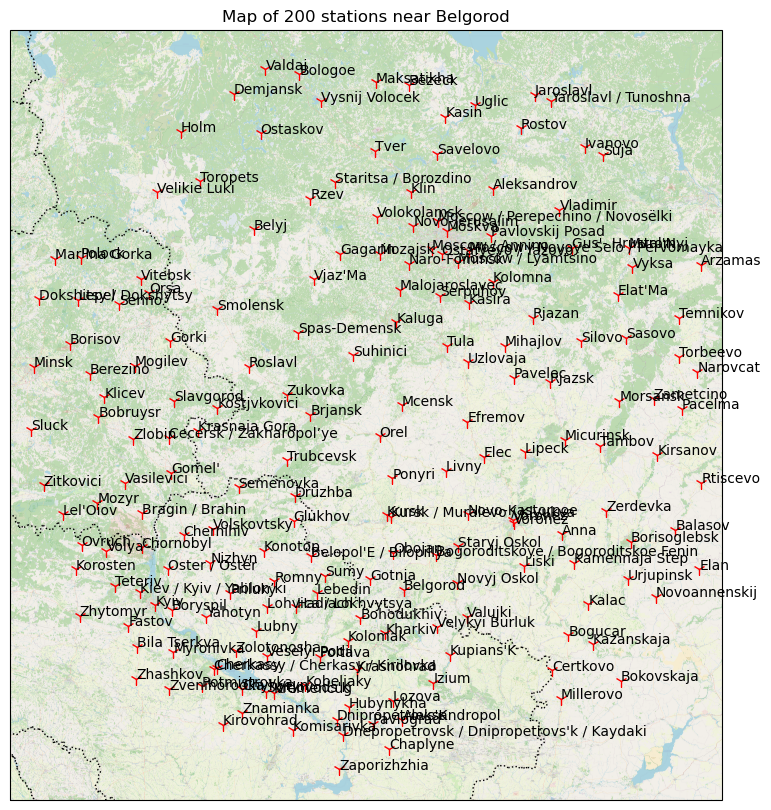

In [8]:
fig = plt.figure(figsize=(20,10))
imagery = OSM()
ax = plt.axes(projection=imagery.crs)
#ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=longitude))
ax.add_image(imagery, 10)
ax.set_extent([min_lon-0.5, max_lon+0.5, min_lat-0.5, max_lat+0.5], ccrs.PlateCarree())

ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)

# Plot the locations twice, first with the red concentric circles,
# then with the blue rectangle.
xs, ys, labels = station['longitude'], station['latitude'], station['name']
ax.plot(xs, ys, transform=ccrs.PlateCarree(),
        marker= '1', color='red', markersize=9, linestyle='')
#ax.plot(xs, ys, transform=ccrs.OSGB(approx=False),
#        marker=, color='blue', markersize=11, linestyle='')
for i in range(len(labels)):
    ax.text(xs[i],ys[i],f'{labels[i]}', transform=ccrs.PlateCarree())

ax.set_title('Map of 200 stations near Belgorod')
plt.show()

In [9]:
from meteostat import Normals, Daily, Monthly
start = datetime(1960, 1, 1)
end = datetime(2020, 12, 31)
df_month_all = pd.DataFrame(columns = df.index)
for i in range(df.shape[0]):
    df_month = Monthly(df.index[i], start, end)
    df_month = df_month.fetch()
    df_month_mean = df_month['tavg']
    df_month_all[df.index[i]] = df_month_mean

df_month_all

id          27906  34003  26898  34013  27707  34009  27921  26997  26894  \
time                                                                        
1960-01-01    NaN   -7.0   -7.3    NaN   -8.2   -6.6    NaN   -6.9    NaN   
1960-02-01    NaN   -8.8   -7.4    NaN   -7.4   -8.2    NaN   -7.1    NaN   
1960-03-01    NaN   -7.6   -5.6    NaN   -6.5   -6.8    NaN   -5.3    NaN   
1960-04-01    NaN    3.8    5.3    NaN    NaN    5.0    NaN    5.9    NaN   
1960-05-01    NaN   13.0   13.3    NaN   12.7   13.5    NaN   13.9    NaN   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2020-08-01   17.6   18.0    NaN   18.3   16.6    NaN    NaN   18.1   17.1   
2020-09-01   15.3   15.3    NaN   15.7   13.6    NaN    NaN   15.2   14.5   
2020-10-01   10.3    9.9    NaN   10.3    9.1    NaN    NaN   10.6    9.7   
2020-11-01    1.6    1.2    NaN    1.4    1.1    NaN    1.0    2.0    2.0   
2020-12-01   -3.8   -4.6    NaN   -4.9   -4.1    NaN   -5.5   -2.9   -2.9   

id          27719  ...  26381  26951  33711  27653  26657  26855  26289  \
time               ...                                                    
1960-01-01    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN  -12.8   
1960-02-01    NaN  ...    NaN    NaN   -4.8    NaN    NaN    NaN  -10.3   
1960-03-01    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN   -6.5   
1960-04-01    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1960-05-01    NaN  ...    NaN    NaN   15.4    NaN    NaN    NaN   11.3   
...           ...  ...    ...    ...    ...    ...    ...    ...    ...   
2020-08-01   17.0  ...    NaN   18.8   21.8   15.5    NaN    NaN    NaN   
2020-09-01   14.1  ...    NaN   15.1   18.5   12.3    NaN    NaN    NaN   
2020-10-01    9.6  ...    NaN   10.8   13.2    7.0    NaN    NaN    NaN   
2020-11-01    1.3  ...    NaN    3.8    3.7   -0.4    3.4    NaN    NaN   
2020-12-01   -5.0  ...    NaN   -0.8   -0.5   -9.0    NaN   -1.0    NaN   

id          34601  34445  33325  
time                             
1960-01-01    NaN    NaN   -4.6  
1960-02-01    NaN    NaN   -4.8  
1960-03-01    NaN    NaN   -2.3  
1960-04-01    NaN    NaN    6.6  
1960-05-01    NaN    NaN   13.2  
...           ...    ...    ...  
2020-08-01    NaN    NaN   20.1  
2020-09-01   20.1    NaN   17.0  
2020-10-01    NaN    NaN   12.3  
2020-11-01    NaN    0.4    4.2  
2020-12-01    NaN   -6.7    0.1  

[675 rows x 134 columns]

In [10]:
sum_df = df_month_all.isnull().sum()
zeros_indices = sum_df.drop(sum_df[sum_df > 30].index)
station = df.loc[zeros_indices.index]
station

name country region    wmo  icao  \
id                                                                        
34003                                Ponyri      RU    KRS  34003  <NA>   
26997                             Trubcevsk      RU    BRY  26997  <NA>   
34110  Bogoroditskoye / Bogoroditskoe Fenin      RU     AL  34110  <NA>   
34202                                Gotnja      RU    BEL  34202  <NA>   
34123                               Voronez      RU    VOR  34123  <NA>   
26976                         Krasnaja Gora      RU    BRY  26976  <NA>   
26781                              Smolensk      RU    SMO  26781  <NA>   
27612                                Moskva      RU    MOS  27612  <NA>   
34300                               Kharkiv      UA     KK  34300  UKHH   
34321                               Valujki      RU    BEL  34321  <NA>   
33377                                 Lubny      UA     MY  33377  <NA>   
27648                               Elat'Ma      RU    RYA  27648  <NA>   
27857                             Zametcino      RU    PNZ  27857  <NA>   
34247                                 Kalac      RU    VOR  34247  <NA>   
34336                               Bogucar      RU    VOR  34336  <NA>   
33345                                  Kyiv      UA     KV  33345  UKKK   
26477                          Velikie Luki      RU    PSK  26477  ULOL   
26850                                 Minsk      BY     MA  26850  UMMS   
33711                            Kirovohrad      UA     KH  33711  UKKG   

       latitude  longitude  elevation           timezone hourly_start  \
id                                                                      
34003   52.3167    36.3000      251.0      Europe/Moscow          NaT   
26997   52.5833    33.7667      180.0      Europe/Moscow          NaT   
34110   51.1667    37.3500      223.0      Europe/Moscow          NaT   
34202   50.8000    35.7667      222.0      Europe/Moscow          NaT   
34123   51.7000    39.2167      149.0      Europe/Moscow   2018-01-26   
26976   53.0167    31.6000      148.0      Europe/Moscow          NaT   
26781   54.7500    32.0667      241.0      Europe/Moscow          NaT   
27612   55.8333    37.6167      156.0      Europe/Moscow   2018-01-26   
34300   49.9667    36.1333      154.0  Europe/Zaporozhye   1932-01-01   
34321   50.2167    38.1000      112.0   Europe/Volgograd          NaT   
33377   50.0000    33.0167      156.0        Europe/Kiev          NaT   
27648   54.9500    41.7667      136.0      Europe/Moscow          NaT   
27857   53.4833    42.6333      133.0      Europe/Moscow          NaT   
34247   50.4167    41.0500       93.0   Europe/Volgograd          NaT   
34336   49.9333    40.5667       83.0   Europe/Volgograd          NaT   
33345   50.4000    30.5667      166.0        Europe/Kiev   1932-01-01   
26477   56.3500    30.6167       98.0      Europe/Moscow   1932-01-01   
26850   53.9333    27.6333      234.0       Europe/Minsk   1999-01-14   
33711   48.5167    32.2000      170.0  Europe/Zaporozhye          NaT   

      hourly_end daily_start  daily_end monthly_start monthly_end  \
id                                                                  
34003        NaT  1959-01-01 2022-11-30    1959-01-01  2021-01-01   
26997        NaT  1955-01-01 2022-11-28    1959-01-01  2021-01-01   
34110        NaT  1889-08-01 2022-11-30    1889-01-01  2021-01-01   
34202        NaT  1936-01-01 2022-11-30    1936-01-01  2022-01-01   
34123 2022-12-07  1918-06-01 2022-11-30    1918-01-01  2021-01-01   
26976        NaT  1930-06-13 2022-11-28    1936-01-01  2021-01-01   
26781        NaT  1944-01-01 2022-11-26    1944-01-01  2021-01-01   
27612 2022-12-07  1936-12-31 2022-01-15    1820-01-01  2021-01-01   
34300 2022-02-24  1936-01-01 2022-10-18    1936-01-01  2022-01-01   
34321        NaT  1936-01-01 2022-11-30    1936-01-01  2021-01-01   
33377        NaT  1936-01-01 2022-10-18    1936-01-01  2021-01-01   
27648        NaT  1886-01-01 202

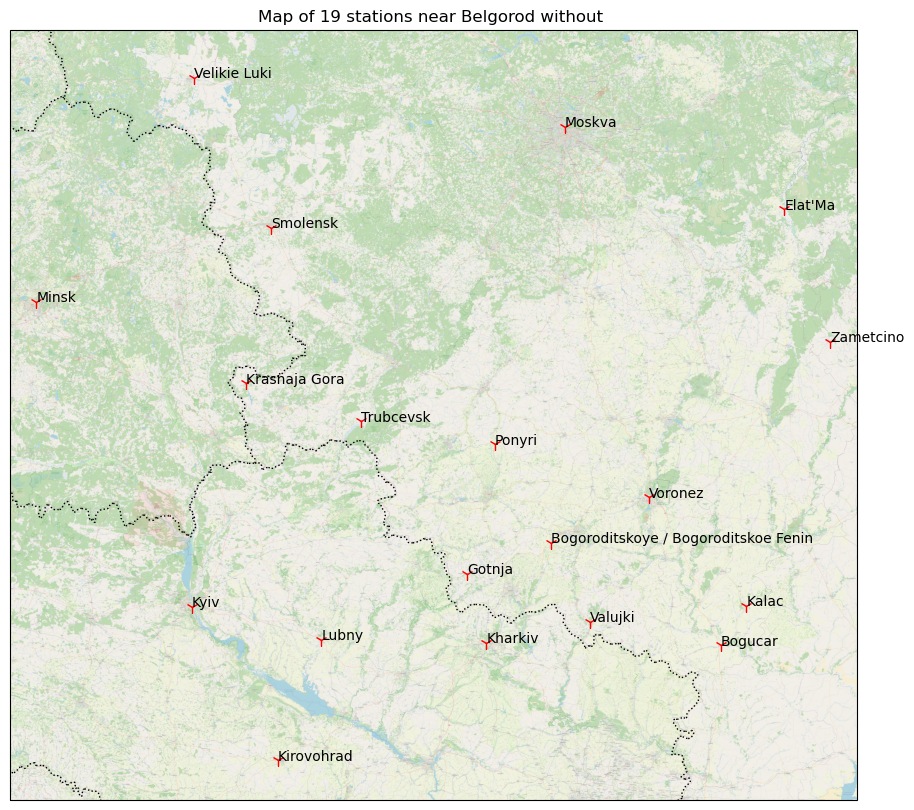

In [11]:
fig = plt.figure(figsize=(20,10))
imagery = OSM()
ax = plt.axes(projection=imagery.crs)
#ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=longitude))
ax.add_image(imagery, 10)

min_lat = station['latitude'].min()
max_lat = station['latitude'].max()
min_lon = station['longitude'].min()
max_lon = station['longitude'].max()

ax.set_extent([min_lon-0.5, max_lon+0.5, min_lat-0.5, max_lat+0.5], ccrs.PlateCarree())

ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)

# Plot the locations twice, first with the red concentric circles,
# then with the blue rectangle.
xs, ys, labels = station['longitude'], station['latitude'], station['name']
ax.plot(xs, ys, transform=ccrs.PlateCarree(),
        marker= '1', color='red', markersize=9, linestyle='')
#ax.plot(xs, ys, transform=ccrs.OSGB(approx=False),
#        marker=, color='blue', markersize=11, linestyle='')
for i in range(len(labels)):
    ax.text(xs[i],ys[i],f'{labels[i]}', transform=ccrs.PlateCarree())

ax.set_title(f'Map of {station.shape[0]} stations near Belgorod without ')
plt.show()

In [12]:
df_t_mean = df_month_all[station.index]
df_t_mean

id          34003  26997  34110  34202  34123  26976  26781  27612  34300  \
time                                                                        
1960-01-01   -7.0   -6.9   -6.2   -5.7   -5.9   -6.8   -8.7   -9.4   -4.4   
1960-02-01   -8.8   -7.1   -7.6   -7.4   -7.2   -6.6   -7.5   -7.7   -3.5   
1960-03-01   -7.6   -5.3   -6.5   -5.7   -5.7   -5.9   -6.8   -5.5   -2.6   
1960-04-01    3.8    5.9    5.3    5.9    5.9    5.4    3.8    5.0    7.5   
1960-05-01   13.0   13.9   13.5   14.0   13.2   13.6   11.9   11.6   14.9   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2020-08-01   18.0   18.1   18.9   18.7   20.1   18.0   16.6   17.6   20.9   
2020-09-01   15.3   15.2   16.2   16.5   16.9   14.8   13.3   13.9   18.4   
2020-10-01    9.9   10.6   10.9   11.3   11.3   10.3    9.0    9.2   12.4   
2020-11-01    1.2    2.0    1.3    1.9    1.6    2.7    1.9    2.2    2.6   
2020-12-01   -4.6   -2.9   -4.9   -3.6   -5.3   -1.7   -2.6   -4.4   -3.1   

id          34321  33377  27648  27857  34247  34336  33345  26477  26850  \
time                                                                        
1960-01-01   -4.2   -4.9   -9.5   -8.6   -4.6    NaN   -4.7   -9.2   -6.8   
1960-02-01   -5.4   -6.0   -8.9   -9.0   -6.2    NaN   -5.0   -8.2   -6.6   
1960-03-01   -3.5   -3.2   -6.3   -7.0   -4.4    NaN   -2.3   -7.1   -5.4   
1960-04-01    7.1    7.2    4.2    4.8    6.8    NaN    7.0    3.9    5.4   
1960-05-01   14.4   15.0   11.5   12.2   13.2    NaN   14.4   11.6   12.5   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2020-08-01   20.2   20.7   16.3   17.3   19.8   21.2   21.4   16.3   17.8   
2020-09-01   17.0   17.9   13.3   14.0   16.1   17.4   18.4   13.3   13.9   
2020-10-01   12.7   12.4    7.9    7.7   11.5   12.3   12.5    9.5   10.5   
2020-11-01    1.7    3.3    0.3   -0.3    1.0    1.3    3.8    2.9    3.6   
2020-12-01   -3.9   -1.6   -7.9   -9.0   -6.4   -5.8   -0.5   -1.6   -1.2   

id          33711  
time               
1960-01-01    NaN  
1960-02-01   -4.8  
1960-03-01    NaN  
1960-04-01    NaN  
1960-05-01   15.4  
...           ...  
2020-08-01   21.8  
2020-09-01   18.5  
2020-10-01   13.2  
2020-11-01    3.7  
2020-12-01   -0.5  

[675 rows x 19 columns]

In [13]:
def data_recovery(dataframe):
    '''data recovery algorytm based on linear regression'''
    
    #find one (first) full station data and name it with X
    idx_min = dataframe.isnull().sum().idxmin()
    X = dataframe[idx_min]
    print(f'True station is {idx_min}')
    
    #define df without X
    df_without_X = dataframe.loc[:, dataframe.columns != idx_min]
    
    #get correlation with other columns 
    corr_with_all = df_without_X.corrwith(X)
    
    # define extra df with additional info 
    extra = pd.DataFrame(columns = ['Correlation', 'R2', 'MAE','MSE', 'Linear equation' ])
    extra['Correlation'] = corr_with_all 
    
    #define final dataframe 
    df_final = pd.DataFrame(X)
    ###data engineering
    for i in range(df_without_X.shape[1]):
        #get one column for regression
        y = df_without_X.iloc[:,i]
        df = pd.concat((X,y), axis = 1)
        #get df with and without nan values
        df_nan = df[df.iloc[:,1].isna()]
        df_drop_nan = df[df.iloc[:,1].notna()]
        
        if df_nan.empty:
            df_final = pd.concat((df_final, y),axis = 1, join = 'inner' )
            continue
            
        # define X and y for train and test
        X_for_split, y_for_split = df_drop_nan.iloc[:,0],df_drop_nan.iloc[:,1]
        X_train, X_test, y_train, y_test = train_test_split( X_for_split,y_for_split, test_size = 0.2)
        X_train, X_test = X_train[:, None], X_test[:, None]
        
        #regression fit and scores
        regr = LinearRegression()
        regr.fit(X_train, y_train)
        y_pred_test = regr.predict(X_test)
        
        #add scores to extra df
        extra['R2'][df_without_X.columns[i]] = r2_score(y_test, y_pred_test)
        extra['MAE'][df_without_X.columns[i]] = mean_absolute_error(y_test, y_pred_test)
        extra['MSE'][df_without_X.columns[i]] = mean_squared_error(y_test, y_pred_test)
        extra['Linear equation'][df_without_X.columns[i]] = \
                    f'Y = {np.round(regr.intercept_,5)} + {np.round(regr.coef_,5)} * X '
        
        #get predictions and put them in final dataframe
        X_for_pred = df_nan.iloc[:,0]
        y_pred = regr.predict(X_for_pred[:, None])
        df_nan.iloc[:,1] = y_pred
        df_concat = pd.concat((df_drop_nan, df_nan)).sort_index()
        df_final = pd.concat((df_final, df_concat.iloc[:,1]),axis = 1, join = 'inner' )

    return df_final, extra
    

In [14]:
df_final, extra = data_recovery(df_t_mean)
extra

True station is 34123


Correlation        R2       MAE       MSE  \
id                                                 
34003     0.998435  0.996661   0.44829   0.34425   
26997     0.996158  0.992909  0.656754   0.72008   
34110     0.999174  0.998347  0.305216  0.166591   
34202     0.998003  0.996169   0.48362  0.412125   
26976     0.993176   0.98362   0.91303  1.516861   
26781     0.991990   0.98054  0.985247  1.554994   
27612     0.993682  0.989878  0.769698  0.904653   
34300     0.997073       NaN       NaN       NaN   
34321     0.998454  0.996137  0.488379  0.366423   
33377     0.995575  0.991698  0.683621  0.745174   
27648     0.996415  0.992695   0.70981   0.78518   
27857     0.997596  0.995053  0.607412  0.583842   
34247     0.997809  0.995139  0.560256    0.5765   
34336     0.997670  0.995266  0.585694  0.531607   
33345     0.992208       NaN       NaN       NaN   
26477     0.985629  0.966479  1.204768  2.719234   
26850     0.986562  0.976176  1.086736  2.023572   
33711     0.992459  0.986464  0.871046  1.252592   

                     Linear equation  
id                                    
34003  Y = -0.78507 + [0.96162] * X   
26997   Y = 0.12012 + [0.91464] * X   
34110   Y = -0.18371 + [0.9723] * X   
34202   Y = 0.26835 + [0.95613] * X   
26976   Y = 0.57212 + [0.88582] * X   
26781    Y = -0.7261 + [0.8829] * X   
27612  Y = -0.66381 + [0.93419] * X   
34300                            NaN  
34321   Y = 1.05471 + [0.96683] * X   
33377   Y = 1.84082 + [0.91936] * X   
27648  Y = -1.93932 + [1.01399] * X   
27857  Y = -1.78011 + [1.05213] * X   
34247   Y = 0.29996 + [1.01457] * X   
34336   Y = 1.15051 + [1.00924] * X   
33345                            NaN  
26477  Y = -0.18918 + [0.85612] * X   
26850    Y = 0.80882 + [0.8427] * X   
33711   Y = 2.42636 + [0.89979] * X

In [15]:
np.round(df_final, 1)

34123  34003  26997  34110  34202  26976  26781  27612  34300  \
time                                                                        
1960-01-01   -5.9   -7.0   -6.9   -6.2   -5.7   -6.8   -8.7   -9.4   -4.4   
1960-02-01   -7.2   -8.8   -7.1   -7.6   -7.4   -6.6   -7.5   -7.7   -3.5   
1960-03-01   -5.7   -7.6   -5.3   -6.5   -5.7   -5.9   -6.8   -5.5   -2.6   
1960-04-01    5.9    3.8    5.9    5.3    5.9    5.4    3.8    5.0    7.5   
1960-05-01   13.2   13.0   13.9   13.5   14.0   13.6   11.9   11.6   14.9   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2020-08-01   20.1   18.0   18.1   18.9   18.7   18.0   16.6   17.6   20.9   
2020-09-01   16.9   15.3   15.2   16.2   16.5   14.8   13.3   13.9   18.4   
2020-10-01   11.3    9.9   10.6   10.9   11.3   10.3    9.0    9.2   12.4   
2020-11-01    1.6    1.2    2.0    1.3    1.9    2.7    1.9    2.2    2.6   
2020-12-01   -5.3   -4.6   -2.9   -4.9   -3.6   -1.7   -2.6   -4.4   -3.1   

            34321  33377  27648  27857  34247  34336  33345  26477  26850  \
time                                                                        
1960-01-01   -4.2   -4.9   -9.5   -8.6   -4.6   -4.8   -4.7   -9.2   -6.8   
1960-02-01   -5.4   -6.0   -8.9   -9.0   -6.2   -6.1   -5.0   -8.2   -6.6   
1960-03-01   -3.5   -3.2   -6.3   -7.0   -4.4   -4.6   -2.3   -7.1   -5.4   
1960-04-01    7.1    7.2    4.2    4.8    6.8    7.1    7.0    3.9    5.4   
1960-05-01   14.4   15.0   11.5   12.2   13.2   14.5   14.4   11.6   12.5   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2020-08-01   20.2   20.7   16.3   17.3   19.8   21.2   21.4   16.3   17.8   
2020-09-01   17.0   17.9   13.3   14.0   16.1   17.4   18.4   13.3   13.9   
2020-10-01   12.7   12.4    7.9    7.7   11.5   12.3   12.5    9.5   10.5   
2020-11-01    1.7    3.3    0.3   -0.3    1.0    1.3    3.8    2.9    3.6   
2020-12-01   -3.9   -1.6   -7.9   -9.0   -6.4   -5.8   -0.5   -1.6   -1.2   

            33711  
time               
1960-01-01   -2.9  
1960-02-01   -4.8  
1960-03-01   -2.7  
1960-04-01    7.7  
1960-05-01   15.4  
...           ...  
2020-08-01   21.8  
2020-09-01   18.5  
2020-10-01   13.2  
2020-11-01    3.7  
2020-12-01   -0.5  

[675 rows x 19 columns]

In [16]:
#pd.set_option('display.max_columns', 20)
df_year_average = df_final.groupby(by=[df_final.index.year]).mean().T
df_year_average_90_20 = df_year_average.iloc[:,29:]
df_year_average_60_90 = df_year_average.iloc[:,:30]
df_year_average_60_90

time       1960      1961      1962      1963      1964      1965       1966  \
34123  6.358333  6.791667  6.500000  5.291667  5.391667  5.191667   8.075000   
34003  5.191667  5.750000  5.325000  4.150000  4.533333  4.016667   7.252297   
26997  6.300000  6.500000  6.005538  4.866667  5.516667  4.700000   7.438417   
34110  6.066667  6.550000  6.300000  5.208333  5.325000  4.916667   8.207886   
34202  6.516667  6.766667  6.741667  5.308333  5.708333  5.108333   8.637608   
26976  6.141667  6.400000  5.675000  4.533333  5.308333  4.516667   7.584657   
26781  4.691667  5.175000  4.308333  3.466667  4.383333  3.108333   5.662500   
27612  4.866667  5.833333  5.116667  3.816667  4.991667  3.916667   5.750000   
34300  8.208333  8.025000  8.183333  6.366667  6.783333  6.550000  10.150000   
34321  7.666667  7.650000  7.875000  6.141667  6.308333  6.233333   9.475000   
33377  7.816667  7.875000  7.833333  6.558333  6.866667  6.258333   9.462500   
27648  4.558333  5.116667  4.783333  2.825000  4.133333  3.425000   5.625000   
27857  5.025000  5.400000  5.233333  3.508333  4.133333  3.966667   6.437500   
34247  7.175000  7.425000  7.691667  6.200000  5.750000  6.058333   8.765343   
34336  7.628144  8.061910  8.289809  6.814640  6.558963  6.862946   9.650000   
33345  7.966667  8.341667  7.791667  6.983333  7.300000  6.458333   9.237500   
26477  4.725000  5.716667  4.533333  3.525000  4.983333  4.091667   5.162500   
26850  5.550000  6.516667  5.358333  4.975000  5.558333  4.525000   6.762500   
33711  8.667741  8.575000  8.321089  7.263394  7.633333  7.253522  10.312500   

time       1967      1968      1969  ...      1981      1982      1983  \
34123  6.509091  4.042857  5.860000  ...  7.500000  7.490909  7.358333   
34003  5.690909  3.228571  4.898785  ...  6.258333  6.545455  6.383333   
26997  6.142959  3.923082  5.480425  ...  6.641667  7.454545  6.950000   
34110  6.481818  4.114286  5.940000  ...  7.116667  7.036364  7.016667   
34202  7.000000  4.685714  6.360000  ...  7.391667  7.427273  7.366667   
26976  6.488175  4.014286  5.600000  ...  6.758333  7.690909  7.216667   
26781  5.090909  2.600000  4.610000  ...  5.466667  6.472727  6.041667   
27612  5.690909  2.657143  4.720000  ...  6.425000  6.681818  6.241667   
34300  8.581818  5.900000  7.900000  ...  8.716667  8.400000  8.516667   
34321  7.736364  5.571429  7.180000  ...  8.383333  7.990909  8.091667   
33377  8.200000  5.828571  7.580000  ...  8.450000  8.981818  8.858333   
27648  4.854545  1.657143  3.840000  ...  5.916667  5.945455  5.458333   
27857  5.045455  2.072580  4.340000  ...  6.308333  6.409091  6.050000   
34247  7.219274  4.914286  6.950000  ...  7.983333  7.663636  7.800000   
34336  8.145455  5.771429  7.590000  ...  8.783333  8.254545  8.708333   
33345  8.618182  6.100000  7.840000  ...  8.425000  9.490909  9.133333   
26477  5.554545  3.000000  4.780000  ...  5.425000  6.754545  6.308333   
26850  6.909091  4.014286  5.840000  ...  6.341667  7.500000  7.441667   
33711  9.081818  6.900000  8.070000  ...  8.700000  9.163636  8.950000   

time       1984      1985      1986      1987      1988      1989      1990  
34123  6.033333  5.183333  5.983333  3.675000  6.133333  8.066667  7.450000  
34003  4.800000  3.850000  5.075000  2.741667  5.258333  7.383333  6.575000  
26997  5.416667  4.008333  5.466667  3.316667  5.683333  7.758333  6.975000  
34110  5.558333  4.658333  5.725000  3.341667  5.725000  7.791667  7.175000  
34202  6.091667  4.725000  6.266667  3.783333  5.925000  8.191667  7.533333  
26976  6.000000  4.350000  6.025000  3.975000  6.291667  8.183333  7.625000  
26781  4.758333  3.333333  4.525000  2.833333  5.091667  6.925000  6.266667  
27612  5.075000  4.000000  4.866667  3.200000  5.525000  7.133333  6.266667  
34300  7.191667  6.141667  7.475000  5.108333  7.108333  9.358333  8.800000  
34321  6.900000  5.775000  6.825000  4.658333  6.716667  8.800000  8.333333  
33377  7.708333  6.100000  7.441667  5.233333  7.158333  9.3

In [17]:
def dixon(df_year_average, crit_value):
    result_df = pd.DataFrame(index=df_year_average.index)
    #dickson
    df_sorted = pd.DataFrame(np.sort(df_year_average.values, axis=1), 
                 index=df_year_average.index, 
                 columns=df_year_average.columns)
    
    result_df['Dixon_Q_stat'] =((df_sorted.iloc[:, 1]-df_sorted.iloc[:, 0])/ \
                            (df_sorted.iloc[:, -1]-df_sorted.iloc[:, 0]))
    result_df['Dixon_Q_crit'] = crit_value
    result_df['Dixon_Q_test_alpha = 0.05'] = np.where(result_df['Dixon_Q_stat']<result_df['Dixon_Q_crit'] , 'Однороден', 'Неоднороден')
    return result_df

In [18]:
result_df_92 = dixon(df_year_average_90_20, 0.376)
print('Dixon_test_1990_2020')
result_df_92

Dixon_test_1990_2020


Dixon_Q_stat  Dixon_Q_crit Dixon_Q_test_alpha = 0.05
34123      0.041064         0.376                 Однороден
34003      0.034268         0.376                 Однороден
26997      0.065332         0.376                 Однороден
34110      0.067184         0.376                 Однороден
34202      0.101045         0.376                 Однороден
26976      0.070968         0.376                 Однороден
26781      0.062588         0.376                 Однороден
27612      0.004062         0.376                 Однороден
34300      0.107432         0.376                 Однороден
34321      0.090782         0.376                 Однороден
33377      0.058900         0.376                 Однороден
27648      0.062753         0.376                 Однороден
27857      0.037801         0.376                 Однороден
34247      0.062437         0.376                 Однороден
34336      0.104402         0.376                 Однороден
33345      0.017997         0.376                 Однороден
26477      0.002211         0.376                 Однороден
26850      0.049661         0.376                 Однороден
33711      0.003518         0.376                 Однороден

In [19]:
result_df_69 = dixon(df_year_average_60_90, 0.376)
print('Dixon_test_1960_1990')
result_df_69

Dixon_test_1960_1990


Dixon_Q_stat  Dixon_Q_crit Dixon_Q_test_alpha = 0.05
34123      0.072484         0.376                 Однороден
34003      0.103695         0.376                 Однороден
26997      0.123468         0.376                 Однороден
34110      0.158378         0.376                 Однороден
34202      0.185894         0.376                 Однороден
26976      0.009335         0.376                 Однороден
26781      0.053950         0.376                 Однороден
27612      0.112793         0.376                 Однороден
34300      0.157025         0.376                 Однороден
34321      0.188591         0.376                 Однороден
33377      0.139509         0.376                 Однороден
27648      0.127668         0.376                 Однороден
27857      0.103519         0.376                 Однороден
34247      0.181691         0.376                 Однороден
34336      0.154491         0.376                 Однороден
33345      0.059242         0.376                 Однороден
26477      0.029940         0.376                 Однороден
26850      0.003608         0.376                 Однороден
33711      0.069614         0.376                 Однороден

In [20]:
def grubs(df_year_average):
    result_df = pd.DataFrame(index=df_year_average.index, columns = ['Grubbs', 'Grubbs_year'])

    for i in range(df_year_average.shape[0]):
        data = df_year_average.iloc[i].to_numpy()
        grubb = np.array(grubbs.two_sided_test_indices(data, alpha=.05))
        if grubb.size != 0:
            result_df['Grubbs'][i] = 'Неоднороден'
            if grubb.size > 1:
                result_df['Grubbs_year'][i] = df_year_average.columns[grubb[0]],df_year_average.columns[grubb[1]]
            else:
                result_df['Grubbs_year'][i] = df_year_average.columns[grubb[0]]
        else:
            result_df['Grubbs'][i] = 'Однороден'
    return result_df

In [21]:
result_grubbs = grubs(df_year_average)
result_grubbs

Grubbs Grubbs_year
34123  Однороден         NaN
34003  Однороден         NaN
26997  Однороден         NaN
34110  Однороден         NaN
34202  Однороден         NaN
26976  Однороден         NaN
26781  Однороден         NaN
27612  Однороден         NaN
34300  Однороден         NaN
34321  Однороден         NaN
33377  Однороден         NaN
27648  Однороден         NaN
27857  Однороден         NaN
34247  Однороден         NaN
34336  Однороден         NaN
33345  Однороден         NaN
26477  Однороден         NaN
26850  Однороден         NaN
33711  Однороден         NaN

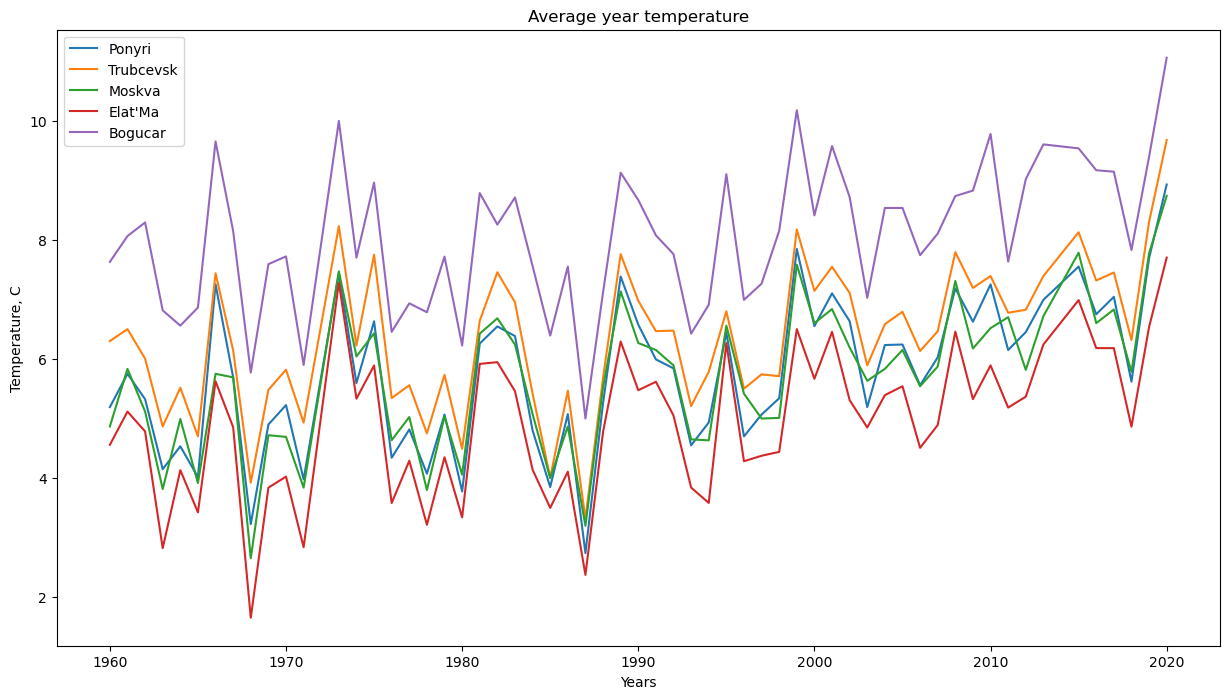

In [22]:
plt.figure(figsize = (15,8))
plt.title('Average year temperature')
plt.plot(df_year_average.loc["34003"], label= station['name'].loc["34003"])
plt.plot(df_year_average.loc["26997"], label= station['name'].loc["26997"])
plt.plot(df_year_average.loc["27612"], label= station['name'].loc["27612"])
plt.plot(df_year_average.loc["27648"], label= station['name'].loc["27648"])
plt.plot(df_year_average.loc["34336"], label= station['name'].loc["34336"])
plt.xlabel('Years')
plt.ylabel('Temperature, C')
plt.legend()

In [23]:
def check_stationarity(y,station_n, lags_plots=14, figsize=(22,8)):
    "Use Series as parameter"
    
    # Creating plots of the DF
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize)
    ax1.set_title(f'{station_n} Temperature Variation')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2);
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3);
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)
    ax4.set_title('Distribution Chart')

    plt.tight_layout()
    
    print('Results of Dickey-Fuller Test:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Critical Value (%s)"%key] = value.round(4)
        
    print(adftest)
    
    if adftest[0].round(2) < adftest[5].round(2):
        print('\nThe Test Statistics is lower than the Critical Value of 5%.\nThe serie seems to be stationary')
    else:
        print("\nThe Test Statistics is higher than the Critical Value of 5%.\nThe serie isn't stationary")

Results of Dickey-Fuller Test:
Test Statistic                  1.3204
p-value                         0.9967
Lags Used                      10.0000
Number of Observations Used    48.0000
Critical Value (1%)            -3.5746
Critical Value (5%)            -2.9240
Critical Value (10%)           -2.6000
dtype: float64

The Test Statistics is higher than the Critical Value of 5%.
The serie isn't stationary


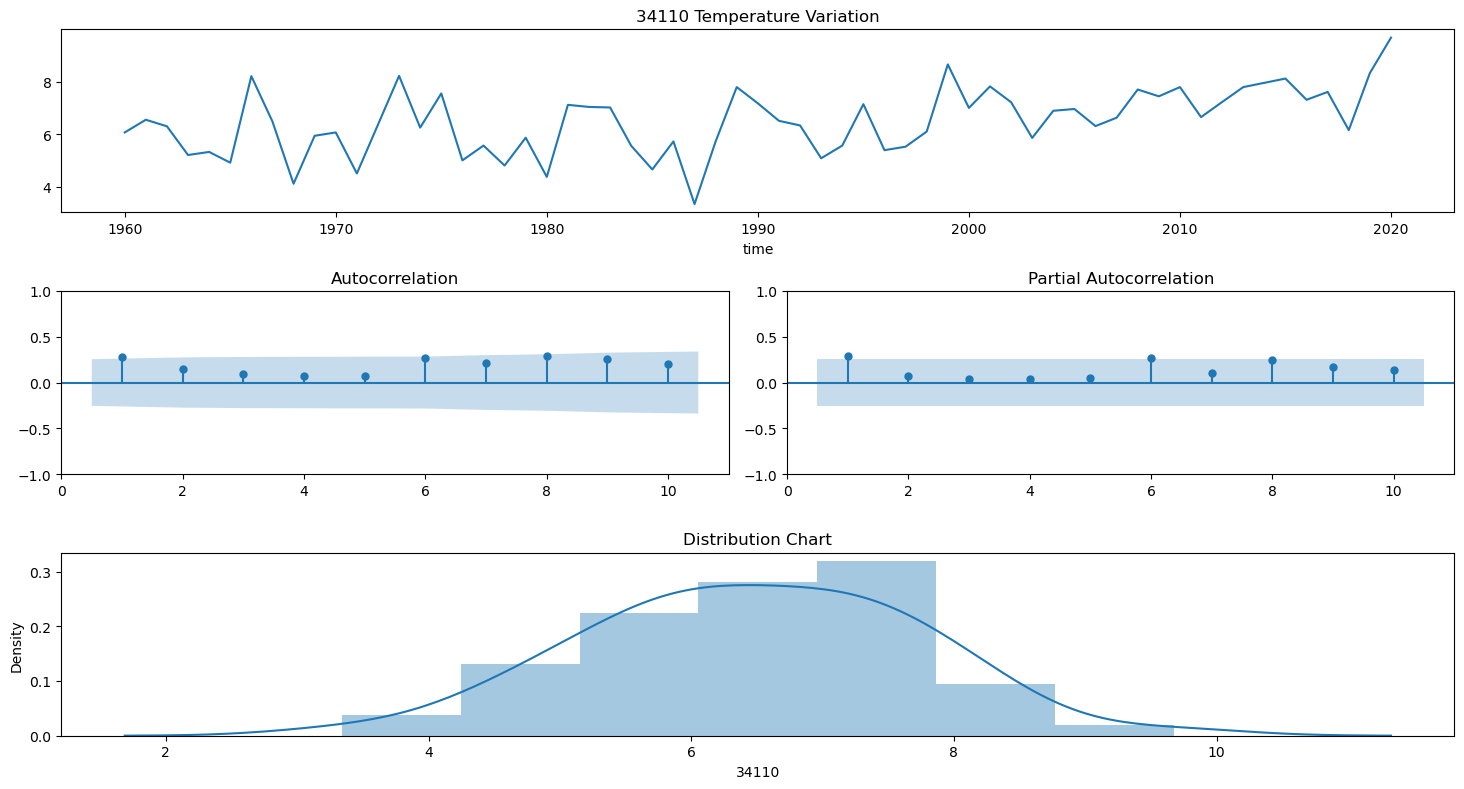

In [24]:
check_stationarity(df_year_average.loc["34110"], station_n = 34110, lags_plots=10, figsize=(22,8))

In [25]:
def stationary_df(df_year_average):
    df_stationary = pd.DataFrame(None)
    for i in range(df_year_average.shape[0]):
        y = df_year_average.iloc[i]
        adfinput = adfuller(y)
        adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
        adftest = round(adftest,4)
        
        for key, value in adfinput[4].items():
            adftest["Critical Value (%s)"%key] = value.round(4)
        
        df_stationary[df_year_average.index[i]] = adftest
    df_stationary = df_stationary.T
    cond = np.less(df_stationary['Test Statistic'], df_stationary['Critical Value (5%)'])
    df_stationary['Stationary'] = np.where(cond, True, False)
    return df_stationary

In [26]:
st_df = stationary_df(df_year_average)
st_df

Test Statistic  p-value  Lags Used  Number of Observations Used  \
34123          1.3438   0.9968       10.0                         48.0   
34003          1.2031   0.9960       10.0                         48.0   
26997         -4.4725   0.0002        0.0                         58.0   
34110          1.3204   0.9967       10.0                         48.0   
34202          1.2945   0.9966       10.0                         48.0   
26976         -4.2840   0.0005        0.0                         58.0   
26781         -4.2039   0.0006        0.0                         58.0   
27612          0.5008   0.9849       10.0                         48.0   
34300         -4.6914   0.0001        0.0                         58.0   
34321          1.5172   0.9976       10.0                         48.0   
33377          1.4710   0.9974       10.0                         48.0   
27648         -5.0323   0.0000        0.0                         58.0   
27857          0.1493   0.9693       10.0                         48.0   
34247         -5.6248   0.0000        0.0                         58.0   
34336         -5.5456   0.0000        0.0                         58.0   
33345         -4.0913   0.0010        0.0                         58.0   
26477         -4.1116   0.0009        0.0                         58.0   
26850         -4.0427   0.0012        0.0                         58.0   
33711         -4.3991   0.0003        0.0                         58.0   

       Critical Value (1%)  Critical Value (5%)  Critical Value (10%)  \
34123              -3.5746              -2.9240               -2.6000   
34003              -3.5746              -2.9240               -2.6000   
26997              -3.5485              -2.9128               -2.5941   
34110              -3.5746              -2.9240               -2.6000   
34202              -3.5746              -2.9240               -2.6000   
26976              -3.5485              -2.9128               -2.5941   
26781              -3.5485              -2.9128               -2.5941   
27612              -3.5746              -2.9240               -2.6000   
34300              -3.5485              -2.9128               -2.5941   
34321              -3.5746              -2.9240               -2.6000   
33377              -3.5746              -2.9240               -2.6000   
27648              -3.5485              -2.9128               -2.5941   
27857              -3.5746              -2.9240               -2.6000   
34247              -3.5485              -2.9128               -2.5941   
34336              -3.5485              -2.9128               -2.5941   
33345              -3.5485              -2.9128               -2.5941   
26477              -3.5485              -2.9128               -2.5941   
26850              -3.5485              -2.9128               -2.5941   
33711              -3.5485              -2.9128               -2.5941   

       Stationary  
34123       False  
34003       False  
26997        True  
34110       False  
34202       False  
26976        True  
26781        True  
27612       False  
34300        True  
34321       False  
33377       False  
27648        True  
27857       False  
34247        True  
34336        True  
33345        True  
26477        True  
26850        True  
33711        True

  1 / 105: ksone
  2 / 105: kstwo
  3 / 105: kstwobign
  4 / 105: norm
  5 / 105: alpha
  6 / 105: anglit
  7 / 105: arcsine
  8 / 105: beta
  9 / 105: betaprime
 10 / 105: bradford
 11 / 105: burr
 12 / 105: burr12
 13 / 105: fisk
 14 / 105: cauchy
 15 / 105: chi
 16 / 105: chi2
 17 / 105: cosine
 18 / 105: dgamma
 19 / 105: dweibull
 20 / 105: expon
 21 / 105: exponnorm
 22 / 105: exponweib
 23 / 105: exponpow
 24 / 105: fatiguelife
 25 / 105: foldcauchy
 26 / 105: f
 27 / 105: foldnorm
 28 / 105: weibull_min
 29 / 105: truncweibull_min
 30 / 105: weibull_max
 31 / 105: genlogistic
 32 / 105: genpareto
 33 / 105: genexpon
 34 / 105: genextreme
 35 / 105: gamma
 36 / 105: erlang
 37 / 105: gengamma
 38 / 105: genhalflogistic
 39 / 105: genhyperbolic
 40 / 105: gompertz
 41 / 105: gumbel_r
 42 / 105: gumbel_l
 43 / 105: halfcauchy
 44 / 105: halflogistic
 45 / 105: halfnorm
 46 / 105: hypsecant
 47 / 105: gausshyper
 48 / 105: invgamma
 49 / 105: invgauss
 50 / 105: geninvgauss
 51 / 1

Text(0, 0.5, 'Frequency')

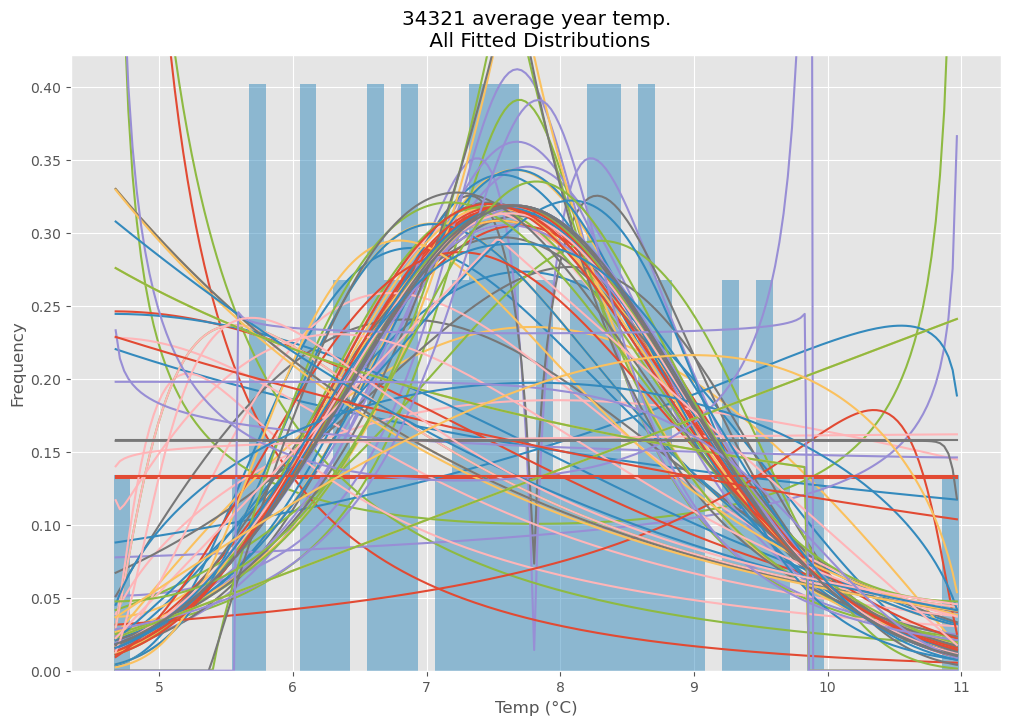

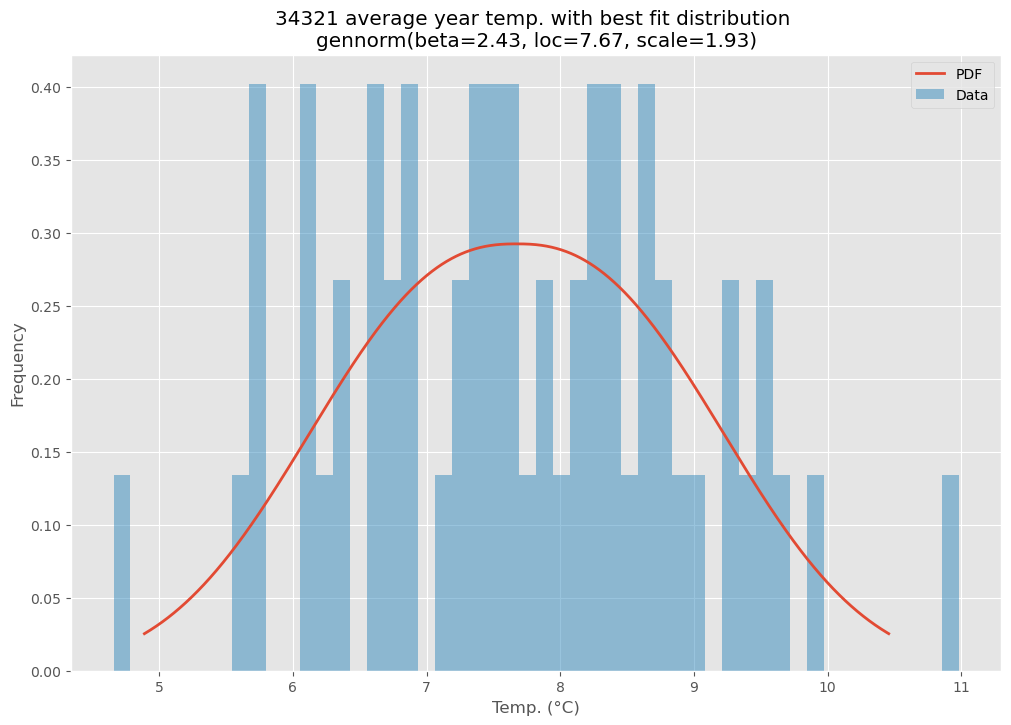

In [27]:
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass

    
    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = df_year_average.loc['34321']

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 200, ax)
best_dist = best_distibutions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'34321 average year temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(u'34321 average year temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')

In [28]:
def best_fit_distribution(data, bins=200, ax=None, method = 'MLE'):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data, method=method)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                E1_error = np.mean(y) - np.mean(pdf)
                E2_max = np.max(y-pdf)
                Cv = st.variation(pdf)
                Cs = st.skew(pdf)
                coef = Cs/Cv
                auto = sm.tsa.acf(pdf, nlags= 1 )[1]
                mean = np.mean(pdf)
                
                error_list = [E1_error,E2_max, coef, Cv, Cs, auto, mean]
                

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        except Exception:
            pass

    
    return sorted(best_distributions, key=lambda x:x[2]), error_list


def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.000000000001, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.000000000001, loc=loc, scale=scale)
    end = dist.ppf(0.9999999999999, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.9999999999999, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

In [29]:
def find_best_approximation(data, method):
    result_df = pd.DataFrame(columns=['Distribution', 'Method', 'E1', 'max E2', 'Cs/Cv', 'Cv', 'Cs', 'R(1)', 'Mean'])
    for i in tqdm(range(data.shape[0])):
        best_distibutions, error_list = best_fit_distribution(data.iloc[i], 200, ax, method)
        best_dist = best_distibutions[0]
        result_df.loc[data.index[i]] = f'{best_dist[0].name}', method, error_list[0], error_list[1], error_list[2], \
                            error_list[3], error_list[4], error_list[5], error_list[6]
    return result_df, best_dist

In [30]:
result_df,best_dist = find_best_approximation(df_year_average, 'MLE')

100%|██████████| 19/19 [03:14<00:00, 10.24s/it]


In [31]:
result_df

Distribution Method        E1    max E2     Cs/Cv        Cv  \
34123            dweibull    MLE  0.001977  1.328804 -1.904160  0.335634   
34003            dweibull    MLE  0.001698  1.473447 -1.846712  0.346906   
26997            dweibull    MLE  0.001684  1.404883 -1.850716  0.345898   
34110            dweibull    MLE  0.001345  1.447087 -1.800152  0.356555   
34202            dweibull    MLE  0.001644  1.419940 -1.843729  0.347407   
26976            gompertz    MLE  0.003903  1.572302 -2.075504  0.307702   
26781            foldnorm    MLE  0.002851  1.016029 -1.969207  0.324221   
27612              mielke    MLE  0.001364  1.515204 -1.794835  0.357862   
34300              burr12    MLE  0.001635  1.403974 -1.840875  0.348112   
34321             gennorm    MLE  0.001798  1.486440 -1.865605  0.343023   
33377            dweibull    MLE  0.002283  1.471322 -1.923702  0.332032   
27648            dweibull    MLE  0.000755  1.447541 -1.687730  0.384284   
27857              dgamma    MLE  0.000776  1.501327 -1.688733  0.384699   
34247              dgamma    MLE  0.000780  0.905001 -1.701900  0.379781   
34336            dweibull    MLE  0.001286  1.485619 -1.782145  0.360671   
33345                burr    MLE  0.004619  1.536895 -2.185362  0.293795   
26477  laplace_asymmetric    MLE  0.003577  1.592971 -2.040565  0.312840   
26850              triang    MLE  0.003515  1.224652 -2.012582  0.317268   
33711            foldnorm    MLE  0.002976  1.481838 -2.001248  0.318937   

             Cs      R(1)      Mean  
34123 -0.639101  0.976887  0.147938  
34003 -0.640634  0.977680  0.159967  
26997 -0.640159  0.977501  0.155646  
34110 -0.641854  0.978189  0.156606  
34202 -0.640524  0.977652  0.156668  
26976 -0.638637  0.975051  0.173587  
26781 -0.638458  0.976255  0.170924  
27612 -0.642304  0.978325  0.163130  
34300 -0.640830  0.977761  0.157997  
34321 -0.639946  0.977378  0.156342  
33377 -0.638731  0.976605  0.159165  
27648 -0.648567  0.979965  0.164729  
27857 -0.649655  0.980127  0.167415  
34247 -0.646349  0.979532  0.156382  
34336 -0.642767  0.978483  0.163879  
33345 -0.642048  0.973582  0.161670  
26477 -0.638370  0.975386  0.174129  
26850 -0.638528  0.976237  0.185164  
33711 -0.638272  0.975649  0.161736

In [32]:
station['0.5%']= df_year_average.quantile(0.005, axis = 1)
station['1%'] =  df_year_average.quantile(0.01, axis = 1)
station['mean']= df_year_average.mean(axis = 1)
station['99%'] =  df_year_average.quantile(0.99, axis = 1)
station['99.5%']= df_year_average.quantile(0.995, axis = 1)

In [33]:
st_drop = station.drop(['icao', 'timezone'], axis = 1)
st_drop_1 = st_drop.drop(st_drop.iloc[:, 7:15], axis = 1)
st_drop_1

name country region    wmo  latitude  \
id                                                                            
34003                                Ponyri      RU    KRS  34003   52.3167   
26997                             Trubcevsk      RU    BRY  26997   52.5833   
34110  Bogoroditskoye / Bogoroditskoe Fenin      RU     AL  34110   51.1667   
34202                                Gotnja      RU    BEL  34202   50.8000   
34123                               Voronez      RU    VOR  34123   51.7000   
26976                         Krasnaja Gora      RU    BRY  26976   53.0167   
26781                              Smolensk      RU    SMO  26781   54.7500   
27612                                Moskva      RU    MOS  27612   55.8333   
34300                               Kharkiv      UA     KK  34300   49.9667   
34321                               Valujki      RU    BEL  34321   50.2167   
33377                                 Lubny      UA     MY  33377   50.0000   
27648                               Elat'Ma      RU    RYA  27648   54.9500   
27857                             Zametcino      RU    PNZ  27857   53.4833   
34247                                 Kalac      RU    VOR  34247   50.4167   
34336                               Bogucar      RU    VOR  34336   49.9333   
33345                                  Kyiv      UA     KV  33345   50.4000   
26477                          Velikie Luki      RU    PSK  26477   56.3500   
26850                                 Minsk      BY     MA  26850   53.9333   
33711                            Kirovohrad      UA     KH  33711   48.5167   

       longitude  elevation      0.5%        1%      mean        99%  \
id                                                                     
34003    36.3000      251.0  2.882869  3.024071  5.768210   8.299818   
26997    33.7667      180.0  3.492527  3.668388  6.363409   8.876545   
34110    37.3500      223.0  3.565726  3.789786  6.461705   9.082182   
34202    35.7667      222.0  4.045024  4.306714  6.826787   9.556909   
34123    39.2167      149.0  3.781679  3.888357  6.829494   9.459636   
26976    31.6000      148.0  3.986393  3.997786  6.607156   9.008000   
26781    32.0667      241.0  2.667667  2.735333  5.323584   7.857789   
27612    37.6167      156.0  2.814571  2.972000  5.696439   8.183255   
34300    36.1333      154.0  5.337917  5.567500  8.154284  10.887636   
34321    38.1000      112.0  4.923131  5.187929  7.671368  10.328000   
33377    33.0167      156.0  5.405952  5.578571  8.111634  10.662727   
27648    41.7667      136.0  1.865321  2.073500  4.956608   7.456400   
27857    42.6333      133.0  2.237615  2.402650  5.377051   7.758236   
34247    41.0500       93.0  4.188226  4.484786  7.245067   9.828509   
34336    40.5667       83.0  5.223714  5.447429  8.035425  10.543091   
33345    30.5667      166.0  5.922500  5.995000  8.427528  11.130727   
26477    30.6167       98.0  3.036250  3.072500  5.608106   8.100000   
26850    27.6333      234.0  4.004143  4.008286  6.585161   9.077667   
33711    32.2000      170.0  5.972750  6.062167  8.610347  11.190000   

           99.5%  
id                
34003   8.613545  
26997   9.274636  
34110   9.377455  
34202   9.828455  
34123   9.902545  
26976   9.308545  
26781   8.106167  
27612   8.459809  
34300  11.130182  
34321  10.654909  
33377  11.045000  
27648   7.578200  
27857   7.888209  
34247  10.041527  
34336  10.798818  
33345  11.497182  
26477   8.363636  
26850   9.188833  
33711  11.572273

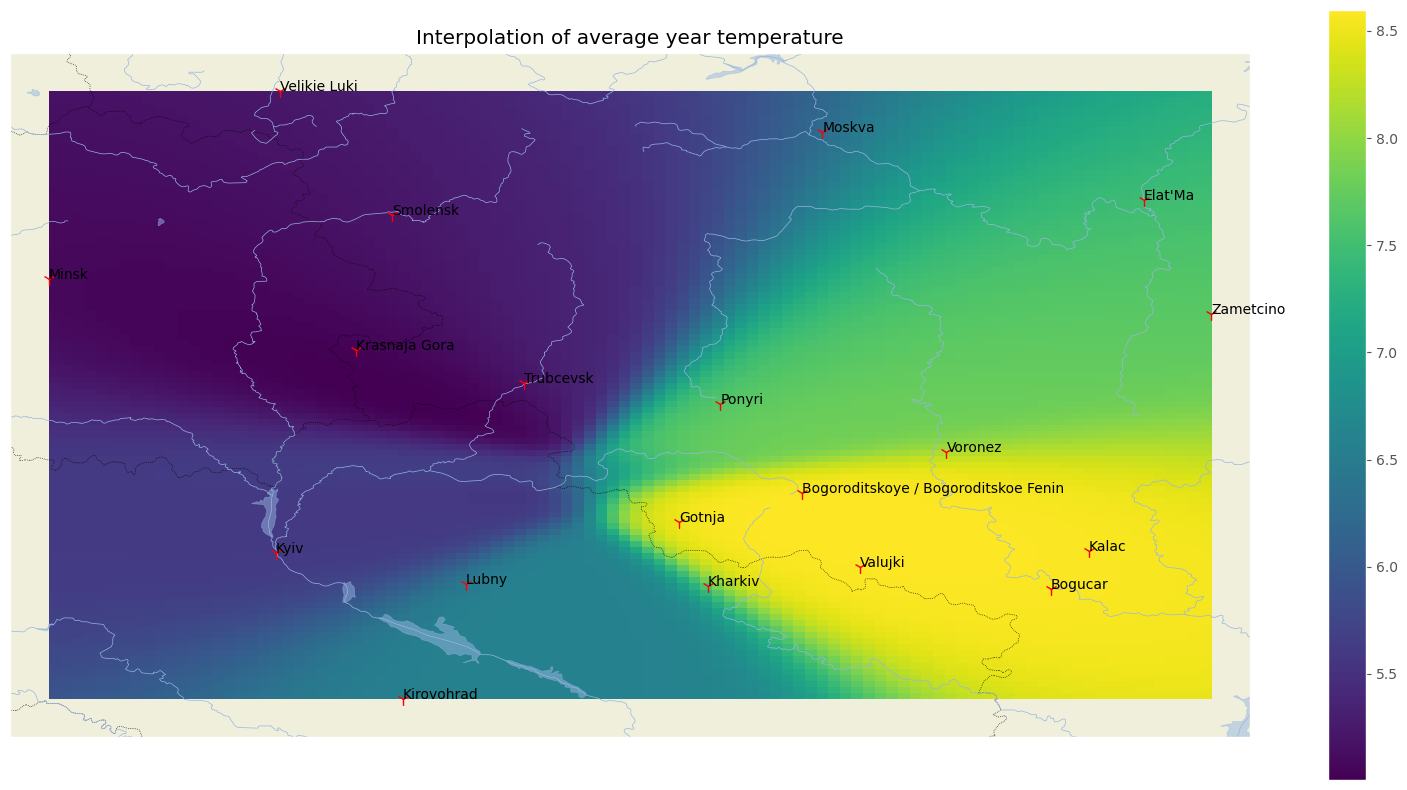

In [34]:
def pointValue(x,y,power,smoothing,xv,yv,values):  
    nominator=0  
    denominator=0  
    for i in range(0,len(values)):  
        dist = sqrt((x-xv[i])*(x-xv[i])+(y-yv[i])*(y-yv[i])+smoothing*smoothing);  
        #If the point is really close to one of the data points, return the data point value to avoid singularities  
        if(dist<0.0000000001):  
            return values[i]  
        nominator=nominator+(values[i]/pow(dist,power))  
        denominator=denominator+(1/pow(dist,power))  
    #Return NODATA if the denominator is zero  
    if denominator > 0:  
        value = nominator/denominator  
    else:  
        value = -9999  
    return value  
  
def invDist(xv,yv,values,xsize=100,ysize=100,power=2,smoothing=0):  
    valuesGrid = np.zeros((ysize,xsize))  
    for x in range(0,xsize):  
        for y in range(0,ysize):  
            valuesGrid[y][x] = pointValue(x,y,power,smoothing,xv,yv,values)  
    return valuesGrid  
      

power=100
smoothing=20

#Creating some data, with each coodinate and the values stored in separated lists  
xv = st_drop_1['latitude']
yv = st_drop_1['longitude']
values = st_drop_1['mean'] 
      
#Creating the output grid (100x100, in the example)  
ti = np.linspace(0, 100, 100)  
XI, YI = np.meshgrid(ti, ti)  
#Creating the interpolation function and populating the output matrix value  
ZI = invDist(xv,yv,values,100,100,power,smoothing)  
# Plotting the result  
#n = plt.normalize(0.0, 100.0)  

min_lat = station['latitude'].min()
max_lat = station['latitude'].max()
min_lon = station['longitude'].min()
max_lon = station['longitude'].max()

fig = plt.figure(figsize=(20,10))
# get the path of the file. It can be found in the repo data directory
img_extent = (min_lon, max_lon, min_lat, max_lat)
ax = plt.axes(projection=ccrs.PlateCarree())

ax.use_sticky_edges = False
# set a margin around the data
ax.set_xmargin(0.05)
ax.set_ymargin(0.10)



ax.set_extent([min_lon-0.5, max_lon+0.5, min_lat-0.5, max_lat+0.5], ccrs.PlateCarree())

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Plot the locations twice, first with the red concentric circles,
# then with the blue rectangle.
xs, ys, labels = station['longitude'], station['latitude'], station['name']
ax.plot(xs, ys, transform=ccrs.PlateCarree(),
        marker= '1', color='red', markersize=9, linestyle='')
plt.imshow(np.flip(ZI), extent=img_extent, transform=ccrs.PlateCarree())
#ax.title('Inv dist interpolation - power: ' + str(power) + ' smoothing: ' + str(smoothing))  

#ax.plot(xs, ys, transform=ccrs.OSGB(approx=False),
#        marker=, color='blue', markersize=11, linestyle='')
for i in range(len(labels)):
    ax.text(xs[i],ys[i],f'{labels[i]}', transform=ccrs.PlateCarree())
plt.colorbar()
ax.set_title(f'Interpolation of average year temperature')
plt.show()